In [89]:
import numpy as np
from hyppo.ksample import MMD
from sparse_shift import KCD
from scipy.stats import wilcoxon
from sparse_shift.datasets import sample_topological, sample_nonlinear_icp_sim
from sparse_shift.plotting import plot_dag
from sparse_shift.testing import test_mechanism_shifts
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import os
import warnings

warnings.simplefilter("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"  # Also affect subprocesses

## 2-variable SCM

In [90]:
# X1 -> X2
true_parents = np.asarray([[0,  0], [1, 0]])
n = 100

g_noise = lambda: np.abs(np.random.standard_t(df=10))
g1_equations = [
    lambda X, U: U,
    lambda X, U: X[0] + U,
]

g2_equations = [
    lambda X, U: U,
    lambda X, U: np.sin(X[0] + U)
]

# 2 settings, X2|X1 changes
Xs = [
    sample_topological(n, g1_equations, g_noise, random_state=1),
    sample_topological(n, g2_equations, g_noise, random_state=2),
]

In [91]:
# Conditional changes
def sample_toy_data(n):
    X = np.random.uniform(0, 1, (n, 1))
    
    X_below = (X < 0.3)[:, 0]
    X_above = (X >= 0.3)[:, 0]
    y0 = 3 + 5*X[:, 0] + X_below * np.random.normal(0, 1, (n)) + X_above * np.random.normal(
        0, np.abs((1 + 7 * (X[:, 0] - 0.3))), (n))
    y1 = 4*X[:, 0] + X_below * np.random.normal(0, 1, (n)) + X_above * np.random.normal(
        0, np.abs((1 + 7 * (X[:, 0] - 0.3))), (n))
    
    return X, np.vstack((y0, y1)).T

n = 1000
X, y_outcomes = sample_toy_data(n)
z = np.random.choice(2, (n))
y = np.asarray([outcomes[i] for outcomes, i in zip(y_outcomes, z)])

Xs = [
    np.hstack((X[z == 0], y[z == 0].reshape(-1, 1))),
    np.hstack((X[z == 1], y[z == 1].reshape(-1, 1)))
]

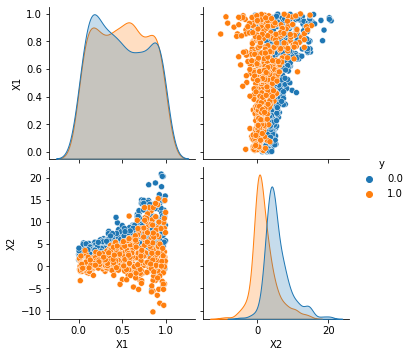

In [92]:
df = pd.DataFrame(
    np.hstack((
        np.vstack(Xs),
        np.hstack([[i]*X.shape[0] for i, X in enumerate(Xs)]).reshape(-1, 1).astype(int)
    )),
    columns=[f'X{i+1}' for i in range(Xs[0].shape[1])] + ['y']
)
sns.pairplot(df, hue='y')
plt.show()

In [70]:
pval_mats = []
n_changes = []
bi_dags = [
    np.asarray([[0,  0], [1, 0]]),
    np.asarray([[0,  1], [0, 0]])
]
alpha = 0.05

for dag in bi_dags:
    print('.', end='')
    num_shifts, pvalues_mat = test_mechanism_shifts(
        Xs, dag,
        test_kwargs={'method': 'gam', 'test': 'ks'},
    )
    pval_mats.append(pvalues_mat[:, 0, 1])
    n_changes.append(np.sum(pvalues_mat <= alpha) // 2) # Number of changing mechanisms in DAG
pval_mats = np.asarray(pval_mats)
n_changes = np.asarray(n_changes)

print('Number of changes (MEC): ', n_changes)
pval_mats

..Number of changes (MEC):  [1 2]


array([[2.28449704e-01, 1.12244181e-97],
       [2.84026314e-09, 1.40108775e-60]])

In [71]:
# Distribution of X changes
def sample_toy_data(n):
    X = np.vstack((
        np.random.uniform(0, 1, (3 * n // 4, 1)),
        np.random.uniform(0, 0.5, (n // 4, 1)),
    ))
    
    X_below = (X < 0.3)[:, 0]
    X_above = (X >= 0.3)[:, 0]
    y0 = 3 + 5*X[:, 0] + X_below * np.random.normal(0, 1, (n)) + X_above * np.random.normal(
        0, np.abs((1 + 7 * (X[:, 0] - 0.3))), (n))
    y1 = 4*X[:, 0] + X_below * np.random.normal(0, 1, (n)) + X_above * np.random.normal(
        0, np.abs((1 + 7 * (X[:, 0] - 0.3))), (n))
    
    return X, y0.reshape(-1, 1), np.asarray([0]* (n // 2) + [1] * (n // 2))

n = 1000
X, y, z = sample_toy_data(n)

Xs = [
    np.hstack((X[z == 0], y[z == 0].reshape(-1, 1))),
    np.hstack((X[z == 1], y[z == 1].reshape(-1, 1)))
]

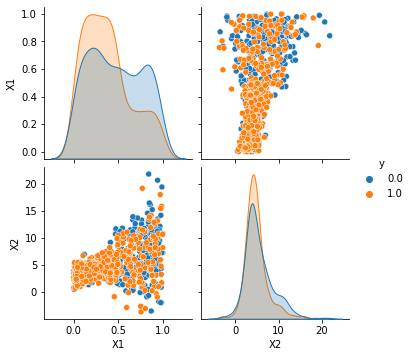

In [72]:
df = pd.DataFrame(
    np.hstack((
        np.vstack(Xs),
        np.hstack([[i]*X.shape[0] for i, X in enumerate(Xs)]).reshape(-1, 1).astype(int)
    )),
    columns=[f'X{i+1}' for i in range(Xs[0].shape[1])] + ['y']
)
sns.pairplot(df, hue='y')
plt.show()

In [73]:
pval_mats = []
n_changes = []
bi_dags = [
    np.asarray([[0,  0], [1, 0]]),
    np.asarray([[0,  1], [0, 0]])
]
alpha = 0.05

for dag in bi_dags:
    print('.', end='')
    num_shifts, pvalues_mat = test_mechanism_shifts(
        Xs, dag,
        test_kwargs={'method': 'gam', 'test': 'ks'},
        # test_kwargs={'test': 'ks'},
        # test='kcd', test_kwargs={'n_reps': 100, 'n_jobs':-2}
    )
    pval_mats.append(pvalues_mat[:, 0, 1])
    n_changes.append(np.sum(pvalues_mat <= alpha) // 2) # Number of changing mechanisms in DAG
pval_mats = np.asarray(pval_mats)
n_changes = np.asarray(n_changes)

print('Number of changes (MEC): ', n_changes)
pval_mats

..Number of changes (MEC):  [1 2]


array([[2.01398192e-08, 1.11368356e-01],
       [8.92222139e-03, 1.20836271e-04]])

In [85]:
# Change x in changing Y regime
def sample_toy_data(n):
    X = np.vstack((
        np.random.uniform(0, 1, (3 * n // 4, 1)),
        np.random.uniform(0.5, 1, (n // 4, 1)),
    ))
    
    X_below = (X < 0.3)[:, 0]
    X_above = (X >= 0.3)[:, 0]
    y0 = 3 + 5*X[:, 0] + X_below * np.random.normal(0, 1, (n)) + X_above * np.random.normal(
        0, np.abs((1 + 7 * (X[:, 0] - 0.3))), (n))
    y1 = 4*X[:, 0] + X_below * np.random.normal(0, 1, (n)) + X_above * np.random.normal(
        0, np.abs((1 + 7 * (X[:, 0] - 0.3))), (n))
    
    return X, y0.reshape(-1, 1), np.asarray([0]* (n // 2) + [1] * (n // 2))

n = 1000
X, y, z = sample_toy_data(n)

Xs = [
    np.hstack((X[z == 0], y[z == 0].reshape(-1, 1))),
    np.hstack((X[z == 1], y[z == 1].reshape(-1, 1)))
]

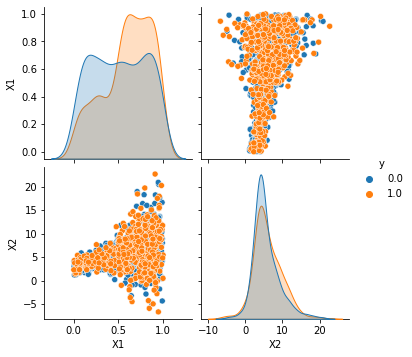

In [86]:
df = pd.DataFrame(
    np.hstack((
        np.vstack(Xs),
        np.hstack([[i]*X.shape[0] for i, X in enumerate(Xs)]).reshape(-1, 1).astype(int)
    )),
    columns=[f'X{i+1}' for i in range(Xs[0].shape[1])] + ['y']
)
sns.pairplot(df, hue='y')
plt.show()

In [87]:
pval_mats = []
n_changes = []
bi_dags = [
    np.asarray([[0,  0], [1, 0]]),
    np.asarray([[0,  1], [0, 0]])
]
alpha = 0.05

for dag in bi_dags:
    print('.', end='')
    num_shifts, pvalues_mat = test_mechanism_shifts(
        Xs, dag,
        test_kwargs={'method': 'gam', 'test': 'ks'},
    )
    pval_mats.append(pvalues_mat[:, 0, 1])
    n_changes.append(np.sum(pvalues_mat <= alpha) // 2) # Number of changing mechanisms in DAG
pval_mats = np.asarray(pval_mats)
n_changes = np.asarray(n_changes)

print('Number of changes (MEC): ', n_changes)
pval_mats

..Number of changes (MEC):  [1 2]


array([[1.19939169e-08, 2.57607261e-01],
       [1.08449150e-04, 5.66202552e-04]])

In [88]:
pval_mats = []
n_changes = []
bi_dags = [
    np.asarray([[0,  0], [1, 0]]),
    np.asarray([[0,  1], [0, 0]])
]
alpha = 0.05

for dag in bi_dags:
    print('.', end='')
    num_shifts, pvalues_mat = test_mechanism_shifts(Xs, dag, test_kwargs={'method': 'gam', 'test': 'ks'})
    pval_mats.append(pvalues_mat[:, 0, 1])
    n_changes.append(np.sum(pvalues_mat <= alpha) // 2) # Number of changing mechanisms in DAG
pval_mats = np.asarray(pval_mats)
n_changes = np.asarray(n_changes)

print('Number of changes (MEC): ', n_changes)
pval_mats

..Number of changes (MEC):  [1 2]


array([[1.19939169e-08, 2.57607261e-01],
       [1.08449150e-04, 5.66202552e-04]])

In [80]:
# X1 -> X2
true_parents = np.asarray([[0,  0], [1, 0]])
n = 100

g_noise = lambda: np.abs(np.random.standard_t(df=10))
g1_equations = [
    lambda X, U: U,
    lambda X, U: X[0] + U,
]

g2_equations = [
    lambda X, U: U,
    lambda X, U: X[0] + U + 2
]

# 2 settings, X2|X1 changes
Xs = [
    sample_topological(n, g1_equations, g_noise, random_state=1),
    sample_topological(n, g2_equations, g_noise, random_state=2),
]

In [ ]:
stat, pvalue = KCD(n_jobs=-2).test(
    np.vstack((Xs[e1][:, parents], Xs[e2][:, parents])),
    np.concatenate((Xs[e1][:, m], Xs[e2][:, m])),
    np.asarray([0] * Xs[e1].shape[0] + [1] * Xs[e2].shape[0]),
    reps=reps,
)

In [ ]:
rep_nchanges = []
for rep in range(20):
    n = 100
    Xs = [
        sample_nonlinear_icp_sim(
            true_parents, n, nonlinearity='id', noise_df=10,
            intervention_targets=targets, intervention='soft',
            combination='multiplicative',# 'additive',
            intervention_shift=3,
            intervention_scale=1,
            random_state=rep
        )
        for targets in [None, 1]
    ]

    if rep == 0:
        df = pd.DataFrame(
            np.hstack((
                np.vstack(Xs),
                np.hstack([[i]*X.shape[0] for i, X in enumerate(Xs)]).reshape(-1, 1).astype(int)
            )),
            columns=[f'X{i+1}' for i in range(Xs[0].shape[1])] + ['y']
        )
        sns.pairplot(df, hue='y', diag_kind='kde')
        plt.show()
    break
    n_changes = []
    for dag in tri_dags:
        print('.', end='')
        num_shifts, pvalues_mat = test_mechanism_shifts(Xs, dag, reps=100, n_jobs=-2)
        n_changes.append(pvalues_mat[:, 0, 1]) # Number of changing mechanisms in DAG
    print('.')
    rep_nchanges.append(n_changes)

rep_nchanges = np.asarray(rep_nchanges)